In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pickle as pkl

with open('/content/drive/MyDrive/Dataset_without_memory/dataset.pickle', 'rb') as f:
    dataset = pkl.load(f)

with open('/content/drive/MyDrive/Dataset_without_memory/labels.pickle', 'rb') as f:
    labels = pkl.load(f)

dataset.shape , labels.shape

((405960, 50), (405960, 5))

In [3]:
labels = labels['1m class']
dataset = dataset.iloc[: , 1:]

In [4]:
import numpy as np
index1 = int(len(dataset) * 7/9)
index2 = int (len(dataset) * 8/9)


dataset_train , labels_train  = np.asarray(dataset[: index1]).astype('float32') , np.asarray(labels[:index1 ]).astype('float32')

dataset_val , labels_val = np.asarray(dataset[index1 : index2 ]).astype('float32') , np.asarray(labels[index1 : index2]).astype('float32')

dataset_test , labels_test = np.asarray(dataset[index2 :  ]).astype('float32') , np.asarray(labels[index2:]).astype('float32')

In [5]:
from sklearn.utils.class_weight import compute_class_weight



class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique ( np.reshape( labels_train , (np.shape(labels_train)[0]))),
                                        y = np.reshape(labels_train ,(np.shape(labels_train)[0]))                                                 
                                    )
class_weights = dict(zip(np.unique(np.reshape(labels_train ,(np.shape(labels_train)[0]))), class_weights))
class_weights


{0.0: 1.1190079598534197, 1.0: 0.9038720278479129}

In [6]:
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

def standardization( dataframe1, dataframe2, dataframe3  ):
  ###we start the for loop form the second column because the first column is timesteps 
  for i in range (dataframe1.shape[1]):
    
    retrn_data = dataframe1[:, i].reshape(-1, 1)

    scaler = StandardScaler()
    retrn_data_standardized = scaler.fit_transform(retrn_data)

    dataframe1[: , i] = retrn_data_standardized.flatten()


##########validation data
    retrn_data = dataframe2[:, i].reshape(-1, 1)

    retrn_data_standardized = scaler.transform(retrn_data)

    dataframe2[: , i] = retrn_data_standardized.flatten()

##########test data

    retrn_data = dataframe3[:, i].reshape(-1, 1)

    retrn_data_standardized = scaler.transform(retrn_data)

    dataframe3[: , i] = retrn_data_standardized.flatten()




  return dataframe1 , dataframe2, dataframe3

dataset_train , dataset_val , dataset_test = standardization(dataset_train , dataset_val , dataset_test)


In [7]:
import pandas as pd
import os


filepath = "/content/drive/MyDrive/parameter_tuning_1min.csv"

# check if the file exists, create it if not
if not os.path.isfile(filepath):
    columns_name = ['learning_rate' , 'num_hidden_layers', 'regularizer', 'num_neurons', 'droput' , 'optimizer' , 
                    'train_loss' , 'val_loss' , 'train_accuracy' , 'val_accuracy', 'test_loss' , 'test_accuracy']
    df = pd.DataFrame(columns=columns_name)  # create an empty dataframe
    df.to_csv(filepath, index=False)  # save as a CSV file with no index


In [38]:
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from tensorflow import keras
from keras import regularizers
import tensorflow

#reproducibility 
np.random.seed(0)
tensorflow.random.set_seed(0)

def Create_model(my_learning_rate , num_hidden_layers, regularizer, num_neurons, droput , optimizer_fun):
    # Define the model
    model = Sequential()

    
    # Add layers
    model.add(Dense(num_neurons, activation='relu', input_shape=(dataset_train.shape[1],) ,kernel_regularizer=regularizers.l1(regularizer), bias_regularizer=regularizers.l1(regularizer)))
    model.add(BatchNormalization())
    model.add(Dropout(droput))
    num_neurons = int(num_neurons/2)


    for i in range(num_hidden_layers):
        model.add(Dense(num_neurons, activation='relu', kernel_regularizer=regularizers.l1(regularizer), bias_regularizer=regularizers.l1(regularizer)))
        model.add(BatchNormalization())
        model.add(Dropout(droput))
        num_neurons = int(num_neurons/2)

# model.add(Dense(128,kernel_regularizer=regularizers.l1(0.5), bias_regularizer=regularizers.l1(0.5)))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))

# model.add(Dense(64,kernel_regularizer=regularizers.l1(0.5), bias_regularizer=regularizers.l1(0.5)))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))

# model.add(Dense(32,kernel_regularizer=regularizers.l1(0.5), bias_regularizer=regularizers.l1(0.5)))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))

    model.add(Dense(1, activation='sigmoid'))

    if (optimizer_fun == 'SGD'):
      optimizer = keras.optimizers.SGD(learning_rate=my_learning_rate)
    else:
      optimizer = keras.optimizers.Adam(learning_rate=my_learning_rate)



    # Compile the model
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'] )

    # Print the summary of the model
    model.summary()

    return model

my_learning_rate = 0.005
num_hidden_layers  = 4
regularizer = 0
num_neurons = 512
dropout = 0.5
optimizer = 'Adam'

model = Create_model(my_learning_rate, num_hidden_layers , regularizer , num_neurons , dropout , optimizer)



Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_75 (Dense)            (None, 512)               25600     
                                                                 
 batch_normalization_63 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dropout_63 (Dropout)        (None, 512)               0         
                                                                 
 dense_76 (Dense)            (None, 256)               131328    
                                                                 
 batch_normalization_64 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 dropout_64 (Dropout)        (None, 256)             

In [39]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


checkpoint_path = '/content/drive/MyDrive/my_best_model_FNN_1min.hdf5'

checkpoint = ModelCheckpoint(filepath=checkpoint_path, 
                             monitor='val_binary_accuracy',
                             verbose=1, 
                             save_best_only=True,
                             mode='max')


earlystopping = EarlyStopping(monitor ='val_binary_accuracy', patience=10, restore_best_weights=True)
 
callback = [checkpoint, earlystopping]

# Train the model
history = model.fit(dataset_train, labels_train, validation_data=[dataset_val , labels_val], epochs=300, batch_size=128, callbacks=callback, class_weight=class_weights)

# Evaluate the model
loss, accuracy = model.evaluate(dataset_test, labels_test, batch_size=128)

print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy*100:.2f}%")




Epoch 1/300
2466/2467 [============================>.] - ETA: 0s - loss: 0.6988 - binary_accuracy: 0.5023
Epoch 1: val_binary_accuracy improved from -inf to 0.50389, saving model to /content/drive/MyDrive/my_best_model_FNN_1min.hdf5
2467/2467 [==============================] - 28s 9ms/step - loss: 0.6988 - binary_accuracy: 0.5023 - val_loss: 0.6934 - val_binary_accuracy: 0.5039
Epoch 2/300
2466/2467 [============================>.] - ETA: 0s - loss: 0.6929 - binary_accuracy: 0.5148
Epoch 2: val_binary_accuracy improved from 0.50389 to 0.50917, saving model to /content/drive/MyDrive/my_best_model_FNN_1min.hdf5
2467/2467 [==============================] - 22s 9ms/step - loss: 0.6929 - binary_accuracy: 0.5148 - val_loss: 0.6928 - val_binary_accuracy: 0.5092
Epoch 3/300
2463/2467 [============================>.] - ETA: 0s - loss: 0.6918 - binary_accuracy: 0.5292
Epoch 3: val_binary_accuracy did not improve from 0.50917
2467/2467 [==============================] - 22s 9ms/step - loss: 0.691

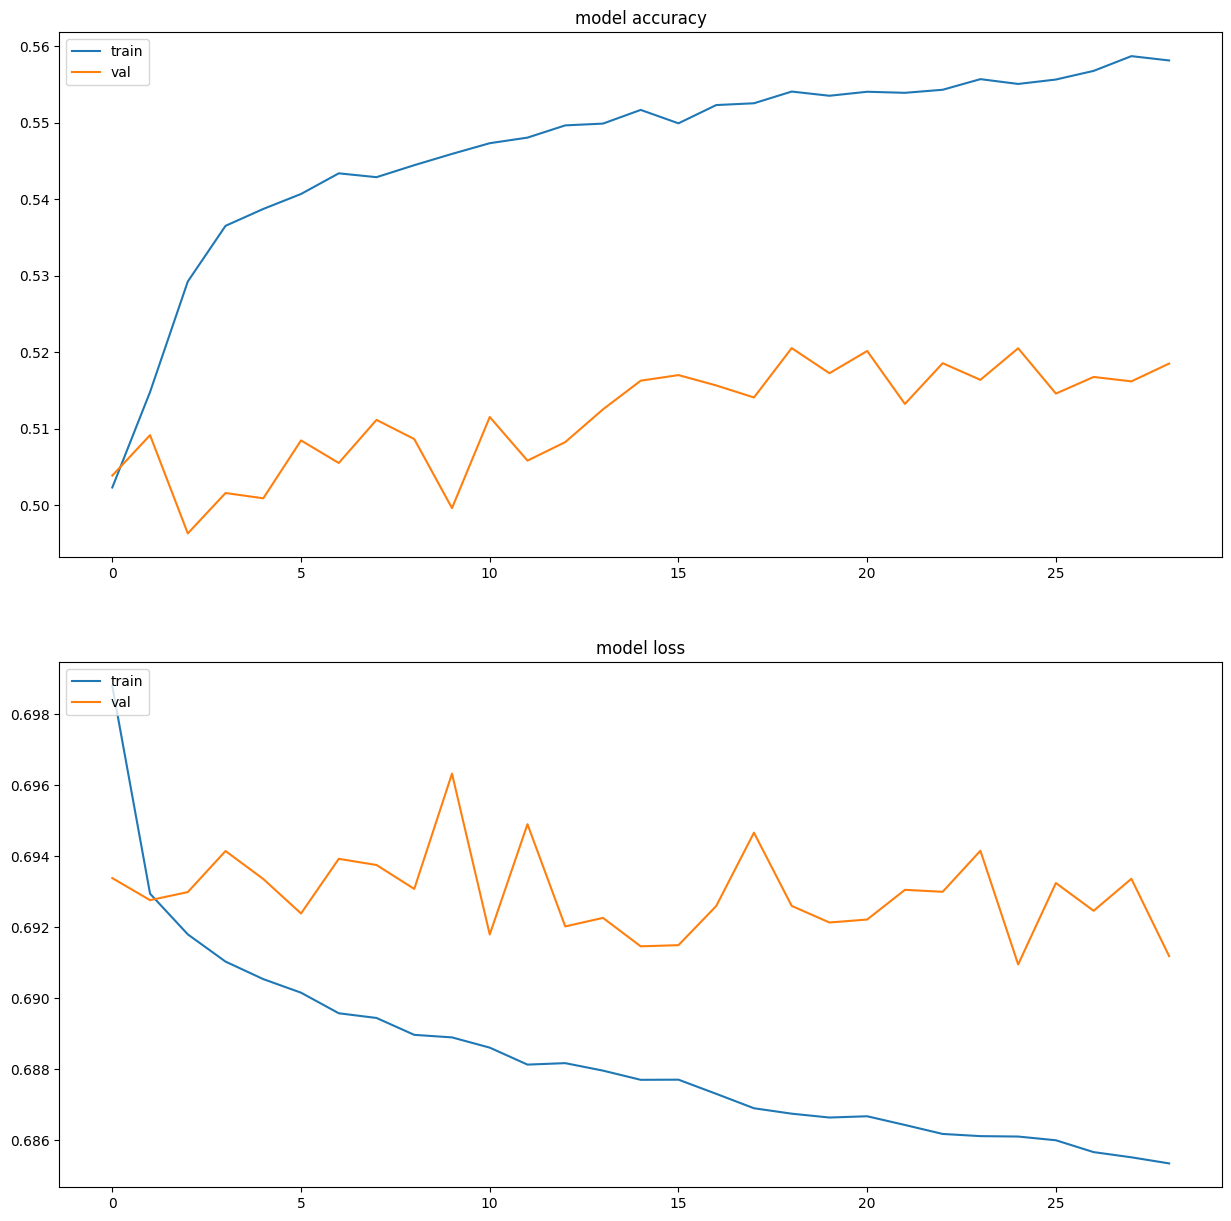

In [40]:
import pandas as pd
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,1, figsize = (15,15))
axs = axs.flatten()
axs[0].plot(history.history['binary_accuracy'])
axs[0].plot(history.history['val_binary_accuracy'])
axs[0].set_title('model accuracy')

axs[0].legend(['train', 'val'], loc='upper left')

# summarize history for loss
axs[1].plot(history.history['loss'])
axs[1].plot(history.history['val_loss'])
axs[1].set_title('model loss')

axs[1].legend(['train', 'val'], loc='upper left')


parameters_to_save = pd.read_csv(filepath)

parameters_to_save = parameters_to_save.append({'learning_rate' : my_learning_rate , 'num_hidden_layers' : num_hidden_layers  , 'regularizer' : regularizer, 
                              'num_neurons' : num_neurons, 'droput': dropout , 'optimizer' : optimizer, 
                              'train_loss' : history.history['loss'][-1] , 'val_loss' : history.history['val_loss'][-1] 
                              , 'train_accuracy' : history.history['binary_accuracy'][-1] , 'val_accuracy' : history.history['val_binary_accuracy'][-1],
                             'test_loss' : f"{loss:.4f}" , 'test_accuracy' : f"{accuracy*100:.2f}%" } , ignore_index = True ) 

parameters_to_save.to_csv(filepath, index=False)